In [1]:
import rpy2
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
base = importr('base')

# the base of rpy2 plotting is matplotlib, thus we need to declare
# it inline in order to see the plots in the notebook
%matplotlib inline

# we need to activate the automatic conversion for pandas
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# load the needed extension for the %%R cell magic
%load_ext rpy2.ipython

import numpy as np
import pandas as pd
import glob
import toml

%config IPCompleter.greedy=True

from IPython.display import display, HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 200

/Users/akshay/Library/Python/3.9/lib/python/site-packages/rpy2/robjects/lib/ggplot2.py:70: UserWarning: This was designed againt ggplot2 versions starting with 3.3. but you have 3.4.2
  warnings.warn(


In [242]:
rootdir = "/Users/akshay/research/burrito"
outdirs = [
    "elk-numparsers-2023-09-20-e5d8209",
]

In [243]:
def read_toml(cfg):
    c = toml.load(cfg)
    num_lps = len(c['machines']['logparser'])
    c['exp']['logparser']['num'] = num_lps
    return c['exp']

def merge_tomls(cfgs):
    merged_cfg = {}
    for cfg in cfgs:
        for key in cfg:
            if key in merged_cfg:
                if type(cfg[key]) != type(merged_cfg[key]):
                    raise Exception(f"mismatched config types: {cfg[key]} vs {merged_cfg[key]}")
                if type(cfg[key]) == int and merged_cfg[key] != cfg[key]:
                    raise Exception(f"int-valued configs must match: {cfg[key]} vs {merged_cfg[key]}")
                if type(cfg[key]) == list:
                    merged_cfg[key] = list(set(cfg[key]).union(set(merged_cfg[key])))
            else:
                merged_cfg[key] = cfg[key]
    return merged_cfg

tomls = {}
for outdir in outdirs:
    od = f"{rootdir}/{outdir}"
    cfgs = glob.glob(f"{od}/*.toml")
    tomls[outdir] = merge_tomls([read_toml(t) for t in cfgs])

tomls

{'elk-numparsers-2023-09-20-e5d8209': {'iterations': 1,
  'pubsub-kafka': [False],
  'local-fastpath': [False],
  'encrypt': ['allow-none'],
  'producer': {'allow-client-sharding': [True],
   'msg-limit': ['30s'],
   'msg-interarrival-ms': [10, 25, 50, 100]},
  'logingest': {'workers': [7]},
  'logparser': {'machines': [1],
   'processes-per-machine': [4, 2, 1],
   'interval-ms': [100],
   'num': 1}}}

In [244]:
# copied from elk-app.py
import itertools
def iter_confs(exp, outdir):
    i = exp['iterations']
    prod = exp['producer']
    ing = exp['logingest']
    par = exp['logparser']
    confs = itertools.product(
        exp['pubsub-kafka'],
        exp['local-fastpath'],
        exp['encrypt'],
        prod['allow-client-sharding'],
        prod['msg-limit'],
        prod['msg-interarrival-ms'],
        ing['workers'],
        par['machines'],
        par['processes-per-machine'],
        par['interval-ms'],
        range(i),
    )
    for conf in confs:
        exp = {
                'pubsub-kafka': conf[0],
                'local-fastpath': conf[1],
                'encrypt': conf[2],
                'producer': {
                    'allow-client-sharding': conf[3],
                    'msg-limit': conf[4],
                    'msg-interarrival-ms': conf[5],
                },
                'logingest': {
                    'workers': conf[6],
                },
                'logparser': {
                    'num': par['num'],
                    'machines': conf[7],
                    'processes-per-machine': conf[8],
                    'interval-ms': conf[9],
                },
                'iteration': conf[10],
        }
        if type(exp['producer']['msg-limit']) == str:
            assert exp['producer']['msg-limit'][-1] == 's', 'time-based msg-limit must be in seconds'
            target_seconds = int(exp['producer']['msg-limit'][:-1])
            inter_seconds = float(int(exp['producer']['msg-interarrival-ms'])) / 1000
            exp['producer']['msg-limit'] = int(target_seconds / inter_seconds) * 16
        template = (
            "{rootdir}/{outdir}/"
            + "kfka={kafka}-"
            + "fp={localfp}-"
            + "cshd={client_shard}-"
            + "enc={encrypt}-"
            + "nmsg={num_msg}-"
            + "intms={msg_inter_ms}-"
            + "iwrk={ingest_workers}-"
            + "pn={parser_machines}-"
            + "pps={parser_procs}-"
            + "prpintms={parser_report_interval_ms}-"
            + "i={i}")
        desc = template.format(
            rootdir=rootdir, outdir=outdir,
            kafka=exp['pubsub-kafka'],
            localfp=exp['local-fastpath'],
            encrypt=exp['encrypt'].replace('-',''),
            client_shard=exp['producer']['allow-client-sharding'],
            num_msg=exp['producer']['msg-limit'],
            msg_inter_ms=exp['producer']['msg-interarrival-ms'],
            ingest_workers=exp['logingest']['workers'],
            parser_machines=exp['logparser']['machines'],
            parser_procs=exp['logparser']['processes-per-machine'],
            parser_report_interval_ms=exp['logparser']['interval-ms'],
            i=0,
        )
        exp['desc'] = desc
        exp['outdir'] = outdir
        yield exp

exps = list(itertools.chain.from_iterable(iter_confs(tomls[outdir], outdir) for outdir in tomls))
len(list(exps))

12

In [249]:
def read_exp(conf):
    outf_prefix = conf['desc']
    suffixes = (
        ["consumer", "logingest", "producer"] 
        + [f'logparser-{i}-{j}' for i in range(conf["logparser"]['num']) for j in range(conf['logparser']['processes-per-machine'])]
    )
    def x():
        for s in suffixes:
            df = pd.read_csv(f"{outf_prefix}-{s}.data")
            for c in conf:
                if type(conf[c]) == dict:
                    for i in conf[c]:
                        k = f"{c}-{i}"
                        if i == 'allow-client-sharding':
                            df[k] = 'clientshard' if conf[c][i] else 'noclientshard'
                        else:
                            df[k] = conf[c][i]
                else:
                    if c == 'pubsub-kafka':
                        df[c] = 'with-kafka' if conf[c] else 'without-kafka'
                    elif c == 'local-fastpath':
                        df[c] = 'with-fp' if conf[c] else 'without-fp'
                    else:
                        df[c] = conf[c]
            df['machine'] = s.split('.')[0]

            found = None
            with open(f"{outf_prefix}-{s}.out", 'r') as f:
                for line in f:
                    if 'producer' not in s:
                        if line.strip().endswith('starting'):
                            found = line.strip().split()[0]
                            break
                    else:
                        if 'got connection, starting' in line:
                            found = line.strip().split()[0]
                            break
            if found == None:
                raise Exception(f'could not find start time for {outf_prefix}_{s}.out')
            df['startTime'] = pd.Timestamp(re.sub(u'\u001b\[.*?[@-~]', '', found))
            yield df
    df = pd.concat(x())
    df['since_start_dur'] = pd.to_timedelta(df['since_start_us'], unit='micro')
    df['realtime'] = df['startTime'] + df['since_start_dur']
    df['expStart'] = df['startTime'].max()
    df['sinceStartAdjMs'] = (df['realtime'] - df['expStart']).astype(np.int64) / int(1e6)
    df = df.drop(['realtime', 'expStart', 'since_start_dur', 'since_start_us', 'startTime'], axis=1)
    return df

df = pd.concat(read_exp(e) for e in exps)
df

,tot_records,tot_bytes,records,bytes,elapsed_us,rate_records_per_sec,rate_bytes_per_sec,pubsub-kafka,local-fastpath,encrypt,producer-allow-client-sharding,producer-msg-limit,producer-msg-interarrival-ms,logingest-workers,logparser-num,logparser-machines,logparser-processes-per-machine,logparser-interval-ms,iteration,desc,outdir,machine,sinceStartAdjMs
0,52,0,47,0,132646,354.324307,0.0,without-kafka,without-fp,allow-none,clientshard,48000,10,7,1,1,4,100,0,/Users/akshay/research/burrito/elk-numparsers-...,elk-numparsers-2023-09-20-e5d8209,consumer,3472.809
1,53,0,1,0,221676,4.511080,0.0,without-kafka,without-fp,allow-none,clientshard,48000,10,7,1,1,4,100,0,/Users/akshay/research/burrito/elk-numparsers-...,elk-numparsers-2023-09-20-e5d8209,consumer,3694.366
2,56,0,3,0,183,16378.585545,0.0,without-kafka,without-fp,allow-none,clientshard,48000,10,7,1,1,4,100,0,/Users/akshay/research/burrito/elk-numparsers-...,elk-numparsers-2023-09-20-e5d8209,consumer,3694.469
3,119,0,63,0,207226,304.015115,0.0,without-kafka,without-fp,allow-none,clientshard,48000,10,7,1,1,4,100,0,/Users/akshay/research/burrito/elk-numparsers-...,elk-numparsers-2023-09-20-e5d8209,consumer,3901.665
4,182,0,63,0,1171,53773.582490,0.0,without-kafka,without-fp,allow-none,clientshard,48000,10,7,1,1,4,100,0,/Users/akshay/research/burrito/elk-numparsers-...,elk-numparsers-2023-09-20-e5d8209,consumer,3902.751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,4703,0,9,0,200115,44.973971,0.0,without-kafka,without-fp,allow-none,clientshard,4800,100,7,1,1,1,100,0,/Users/akshay/research/burrito/elk-numparsers-...,elk-numparsers-2023-09-20-e5d8209,logparser-0-0,51710.788
240,4714,0,11,0,312687,35.178949,0.0,without-kafka,without-fp,allow-none,clientshard,4800,100,7,1,1,1,100,0,/Users/akshay/research/burrito/elk-numparsers-...,elk-numparsers-2023-09-20-e5d8209,logparser-0-0,52023.317
241,4724,0,10,0,190695,52.439539,0.0,without-kafka,without-fp,allow-none,clientshard,4800,100,7,1,1,1,100,0,/Users/akshay/research/burrito/elk-numparsers-...,elk-numparsers-2023-09-20-e5d8209,logparser-0-0,52213.863
242,4728,0,4,0,213,18770.089862,0.0,without-kafka,without-fp,allow-none,clientshard,4800,100,7,1,1,1,100,0,/Users/akshay/research/burrito/elk-numparsers-...,elk-numparsers-2023-09-20-e5d8209,logparser-0-0,52213.929


/Users/akshay/Library/Python/3.9/lib/python/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


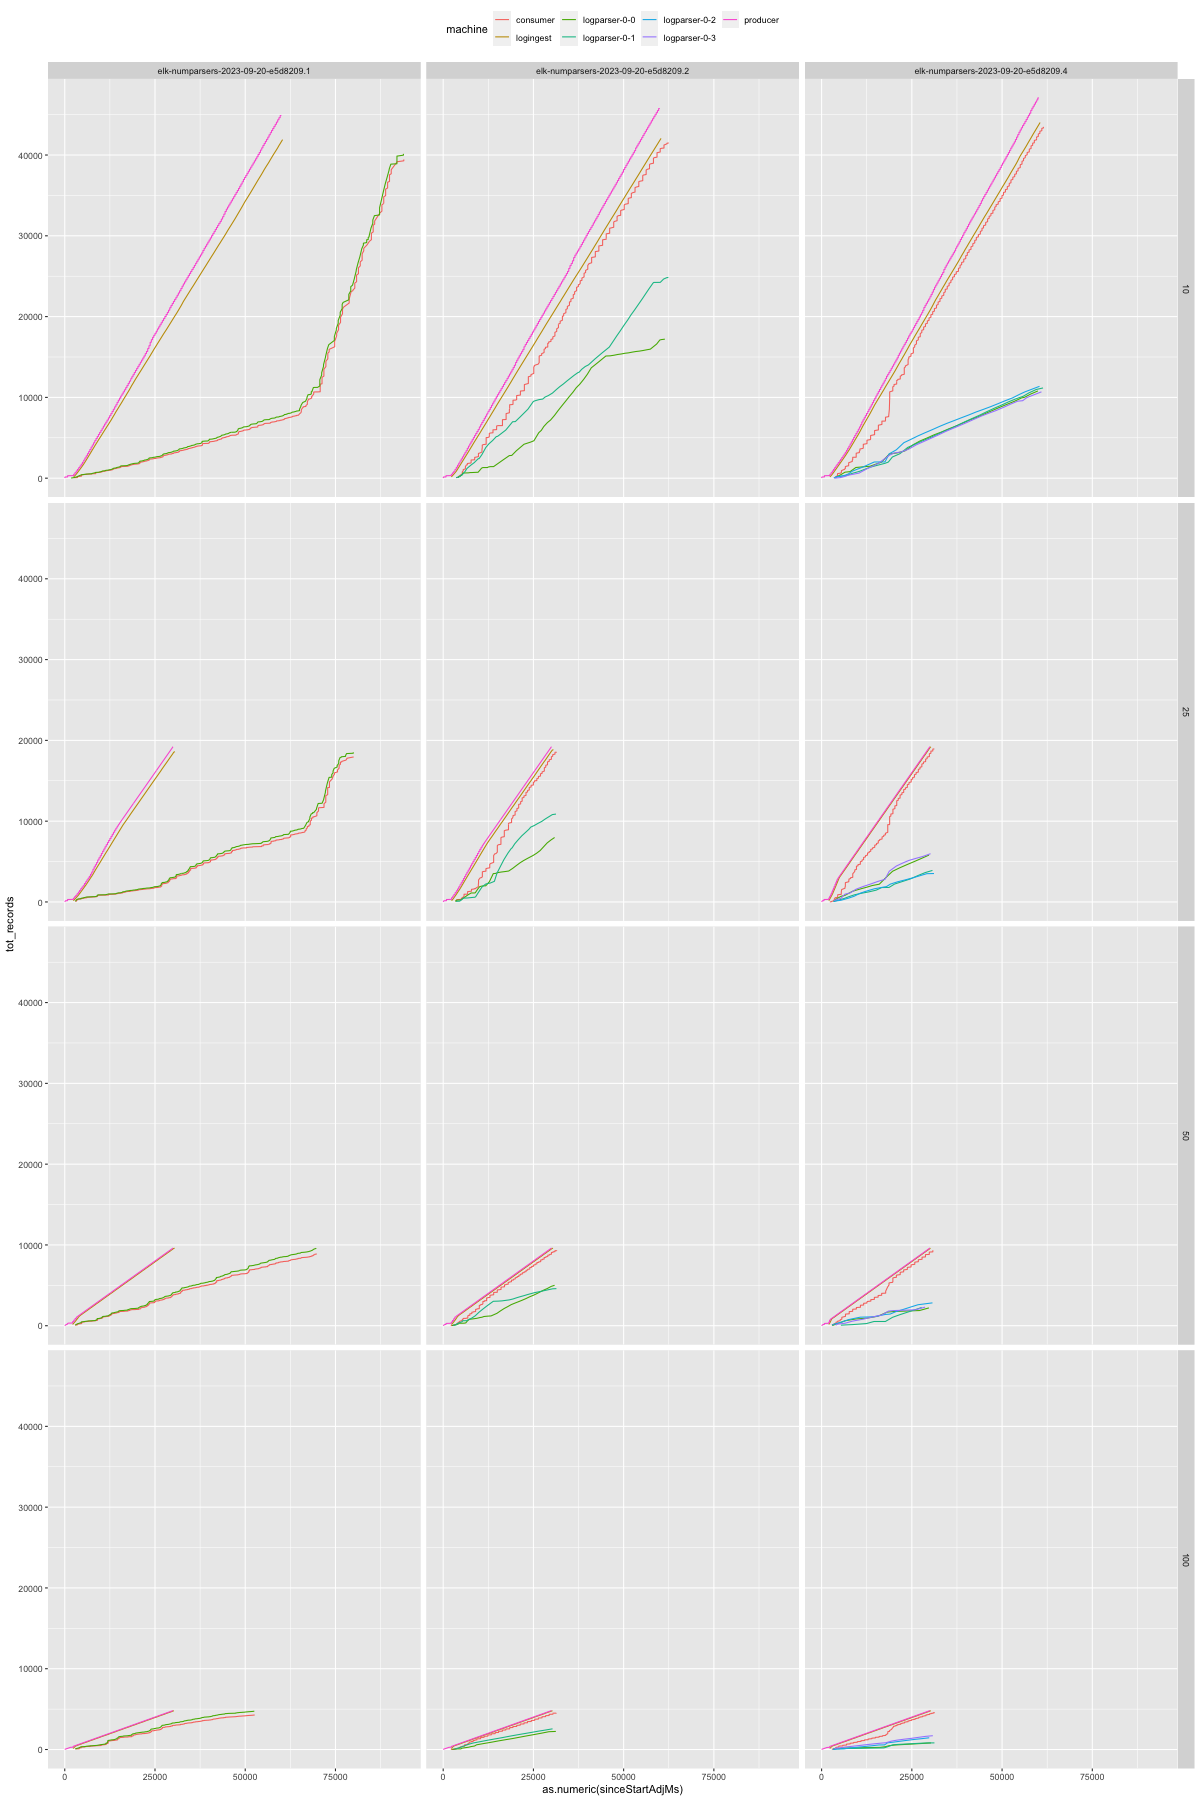

In [250]:
%%R -i df -w 1200 -h 1800

# zoom in
library(ggplot2)

ggplot(df, aes(
    x=as.numeric(sinceStartAdjMs),
    y=tot_records, 
    colour=machine, 
    )) + 
    geom_line() +
    facet_grid(df$"producer-msg-interarrival-ms" ~ interaction(df$outdir, df$"logparser-processes-per-machine")) +
    theme(legend.position = "top")

In [251]:
def lat_agg_group(g):
    tot_records = g['tot_records'].max()
    g['frac_records'] = (g['tot_records'] / tot_records) * 1000 // 10
    times = g[g["machine"] == "consumer"]
    times = times[["machine", "frac_records", "sinceStartAdjMs"]]
    def latency(d):
        cons = d[d["machine"] == "consumer"]
        return (cons['sinceStartAdjMs'].median()) / 1e3
    latency = times.groupby(["frac_records"]).apply(latency).dropna()
    return latency.quantile([0.05, 0.25, 0.5, 0.75, 0.95])

tmp = df[[
    "outdir",
    "pubsub-kafka",
    "encrypt",
    "local-fastpath", 
    "producer-allow-client-sharding",
    "producer-msg-interarrival-ms", 
    "logparser-processes-per-machine",
    "machine",
    "sinceStartAdjMs",
    "tot_records",
]]
group_cols = [
    "outdir",
    "pubsub-kafka",
    "encrypt",
    "local-fastpath", 
    "producer-allow-client-sharding",
    "producer-msg-interarrival-ms", 
    "logparser-processes-per-machine",
]
lat_df = tmp.groupby(group_cols).apply(lat_agg_group).reset_index()
#lat_df = lat_df.melt(id_vars = group_cols, value_vars=[0.05, 0.25, 0.5, 0.75, 0.95])
lat_df

,outdir,pubsub-kafka,encrypt,local-fastpath,producer-allow-client-sharding,producer-msg-interarrival-ms,logparser-processes-per-machine,0.05,0.25,0.5,0.75,0.95
0,elk-numparsers-2023-09-20-e5d8209,without-kafka,allow-none,without-fp,clientshard,10,1,22.128715,67.286906,76.138681,83.688127,89.953119
1,elk-numparsers-2023-09-20-e5d8209,without-kafka,allow-none,without-fp,clientshard,10,2,8.234454,21.394972,33.998321,46.687362,58.256968
2,elk-numparsers-2023-09-20-e5d8209,without-kafka,allow-none,without-fp,clientshard,10,4,8.771379,21.045382,33.569339,47.518112,58.730113
3,elk-numparsers-2023-09-20-e5d8209,without-kafka,allow-none,without-fp,clientshard,25,1,12.893914,36.168501,64.480699,72.325716,76.319426
4,elk-numparsers-2023-09-20-e5d8209,without-kafka,allow-none,without-fp,clientshard,25,2,6.520926,12.994604,18.093869,23.850910,29.529107
5,elk-numparsers-2023-09-20-e5d8209,without-kafka,allow-none,without-fp,clientshard,25,4,4.913194,10.246285,18.589326,24.101009,29.580530
6,elk-numparsers-2023-09-20-e5d8209,without-kafka,allow-none,without-fp,clientshard,50,1,5.885229,21.655630,34.199407,51.057661,67.574315
7,elk-numparsers-2023-09-20-e5d8209,without-kafka,allow-none,without-fp,clientshard,50,2,4.441069,10.450887,16.508389,23.847755,29.671173
8,elk-numparsers-2023-09-20-e5d8209,without-kafka,allow-none,without-fp,clientshard,50,4,4.320109,10.472341,18.476680,24.280037,29.837763
9,elk-numparsers-2023-09-20-e5d8209,without-kafka,allow-none,without-fp,clientshard,100,1,4.573248,13.341301,23.723786,33.958903,47.796006


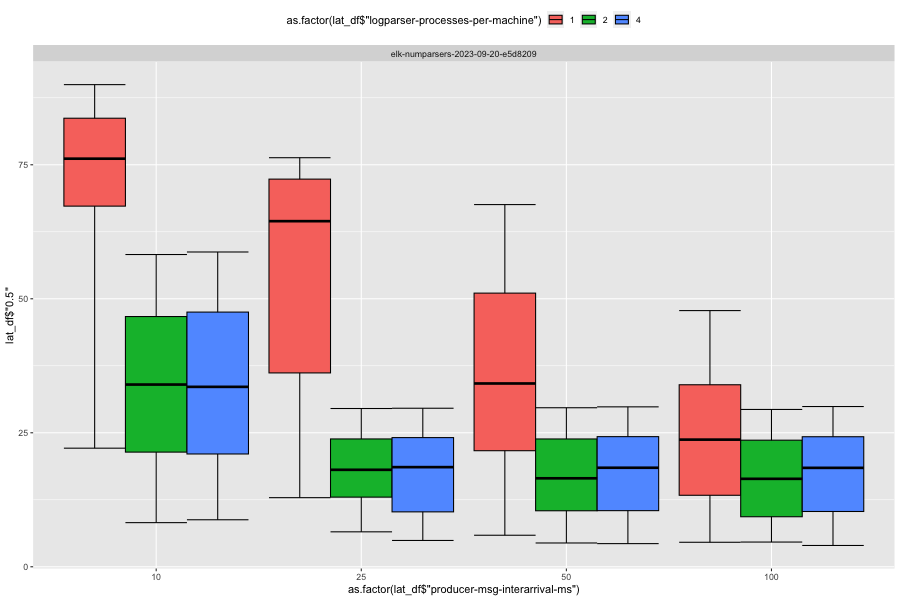

In [252]:
%%R -i lat_df -w 900 -h 600

ggplot(lat_df, aes(x = as.factor(lat_df$"producer-msg-interarrival-ms"), fill = as.factor(lat_df$"logparser-processes-per-machine"))) +
    geom_errorbar(aes(ymin=lat_df$"0.05", ymax=lat_df$"0.95"), position="dodge") +
    geom_crossbar(aes(ymin=lat_df$"0.25", y=lat_df$"0.5", ymax = lat_df$"0.75"), position="dodge") +
    facet_wrap(~outdir) +
    theme(legend.position = "top")

Now summarize each configuration-node as its average slope. If the lines above are not straight, then representing each config-node as a single overall slope would not be a good representation.

In [254]:
def agg_group(g):
    last = g.tail(1)
    first = g.head(1)
    g_elapsed_us = last['sinceStartAdjMs'].values[0] - first['sinceStartAdjMs'].values[0]
    g_tot_records = last['tot_records']
    records_per_s = g_tot_records * 1e6 / g_elapsed_us
    return records_per_s

slopes_df = df.groupby([
    "machine", 
    "pubsub-kafka",
    "encrypt",
    "local-fastpath", 
    "producer-allow-client-sharding",
    "producer-msg-interarrival-ms", 
    "logparser-processes-per-machine",
    ]).apply(agg_group).reset_index(name="records_per_s")
slopes_df

,machine,pubsub-kafka,encrypt,local-fastpath,producer-allow-client-sharding,producer-msg-interarrival-ms,logparser-processes-per-machine,level_7,records_per_s
0,consumer,without-kafka,allow-none,without-fp,clientshard,10,1,668,431902.352192
1,consumer,without-kafka,allow-none,without-fp,clientshard,10,2,553,705462.125123
2,consumer,without-kafka,allow-none,without-fp,clientshard,10,4,530,750067.340824
3,consumer,without-kafka,allow-none,without-fp,clientshard,25,1,556,233189.002116
4,consumer,without-kafka,allow-none,without-fp,clientshard,25,2,259,666802.383166
...,...,...,...,...,...,...,...,...,...
59,producer,without-kafka,allow-none,without-fp,clientshard,50,2,600,319997.536019
60,producer,without-kafka,allow-none,without-fp,clientshard,50,4,600,319999.338668
61,producer,without-kafka,allow-none,without-fp,clientshard,100,1,300,159998.746676
62,producer,without-kafka,allow-none,without-fp,clientshard,100,2,300,160001.173342


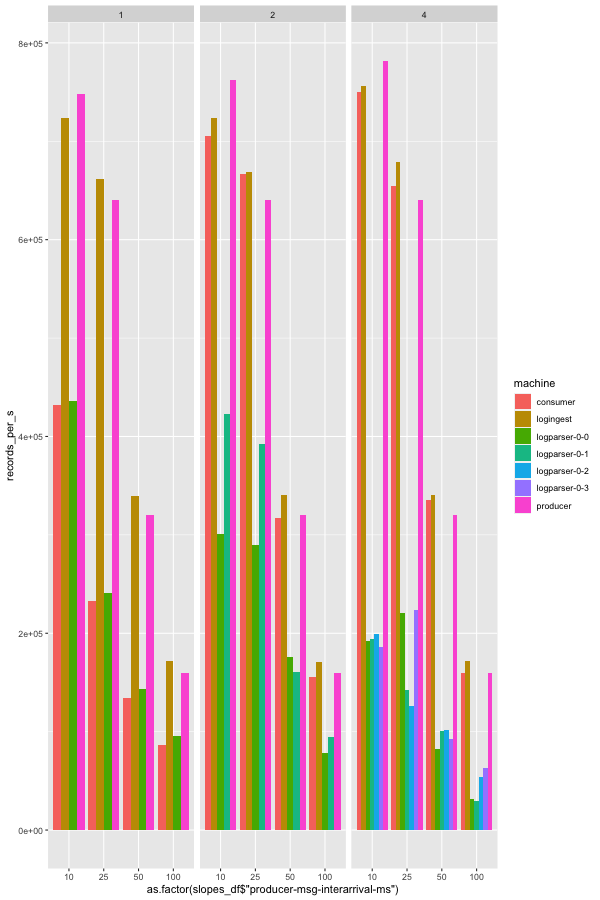

In [259]:
%%R -i slopes_df -w 600 -h 900

ggplot(slopes_df, aes(
    x=as.factor(slopes_df$"producer-msg-interarrival-ms"),
    y=records_per_s,
    fill=machine)) +
    geom_col(position="dodge") +
    facet_wrap(~slopes_df$"logparser-processes-per-machine") +
    theme(
        strip.text.y = element_text(angle = 0)
    )

Without kafka, adding a second parser forces the connection into service-side ordering mode. Does that help?
We consider with the other assumptions on (no kakfa, allow no encryption, allow fp, allow client sharding).

In [260]:
df_num_parsers = slopes_df[
    (slopes_df["pubsub-kafka"] == "without-kafka") &
    (slopes_df["encrypt"] == "allow-none") &
    (slopes_df["local-fastpath"] == "without-fp") &
    (slopes_df["producer-allow-client-sharding"] == "clientshard") &
    ((slopes_df["machine"] == "consumer") | (slopes_df["machine"].str.startswith("logparser")))
]
df_num_parsers

,machine,pubsub-kafka,encrypt,local-fastpath,producer-allow-client-sharding,producer-msg-interarrival-ms,logparser-processes-per-machine,level_7,records_per_s
0,consumer,without-kafka,allow-none,without-fp,clientshard,10,1,668,431902.352192
1,consumer,without-kafka,allow-none,without-fp,clientshard,10,2,553,705462.125123
2,consumer,without-kafka,allow-none,without-fp,clientshard,10,4,530,750067.340824
3,consumer,without-kafka,allow-none,without-fp,clientshard,25,1,556,233189.002116
4,consumer,without-kafka,allow-none,without-fp,clientshard,25,2,259,666802.383166
5,consumer,without-kafka,allow-none,without-fp,clientshard,25,4,254,654138.118555
6,consumer,without-kafka,allow-none,without-fp,clientshard,50,1,641,133785.667149
7,consumer,without-kafka,allow-none,without-fp,clientshard,50,2,282,317074.166192
8,consumer,without-kafka,allow-none,without-fp,clientshard,50,4,244,335632.334011
9,consumer,without-kafka,allow-none,without-fp,clientshard,100,1,445,86143.087115


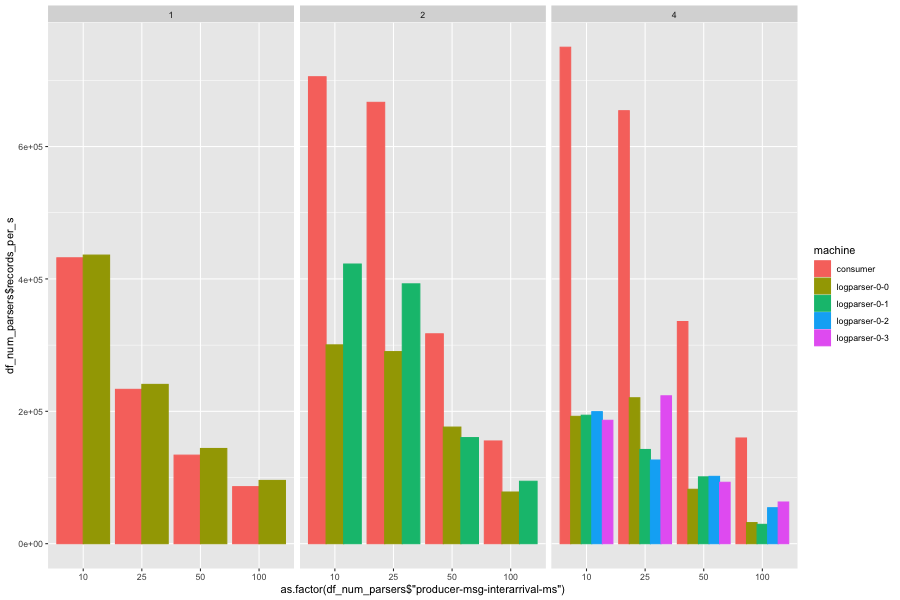

In [261]:
%%R -i df_num_parsers -w 900 -h 600

ggplot(df_num_parsers, aes(
    x = as.factor(df_num_parsers$"producer-msg-interarrival-ms"),
    y = df_num_parsers$"records_per_s",
    colour = machine, fill=machine
    )) +
    geom_col(position = "dodge") +
    facet_wrap(~df_num_parsers$"logparser-processes-per-machine")

In [262]:
tput_consumers = df_num_parsers[df_num_parsers['machine'] == 'consumer']
tput_consumers

,machine,pubsub-kafka,encrypt,local-fastpath,producer-allow-client-sharding,producer-msg-interarrival-ms,logparser-processes-per-machine,level_7,records_per_s
0,consumer,without-kafka,allow-none,without-fp,clientshard,10,1,668,431902.352192
1,consumer,without-kafka,allow-none,without-fp,clientshard,10,2,553,705462.125123
2,consumer,without-kafka,allow-none,without-fp,clientshard,10,4,530,750067.340824
3,consumer,without-kafka,allow-none,without-fp,clientshard,25,1,556,233189.002116
4,consumer,without-kafka,allow-none,without-fp,clientshard,25,2,259,666802.383166
5,consumer,without-kafka,allow-none,without-fp,clientshard,25,4,254,654138.118555
6,consumer,without-kafka,allow-none,without-fp,clientshard,50,1,641,133785.667149
7,consumer,without-kafka,allow-none,without-fp,clientshard,50,2,282,317074.166192
8,consumer,without-kafka,allow-none,without-fp,clientshard,50,4,244,335632.334011
9,consumer,without-kafka,allow-none,without-fp,clientshard,100,1,445,86143.087115


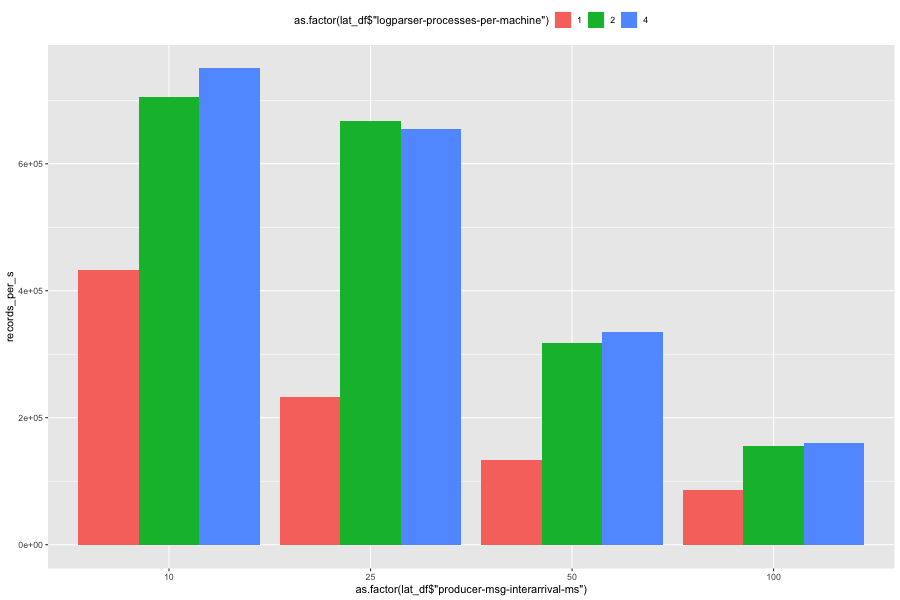

In [263]:
%%R -i tput_consumers -w 900 -h 600

ggplot(tput_consumers, aes(x = as.factor(lat_df$"producer-msg-interarrival-ms"), fill = as.factor(lat_df$"logparser-processes-per-machine"))) +
    geom_col(aes(y=records_per_s), position="dodge") +
    theme(legend.position = "top")